# Facial Expression Recognition (FER) with Vision Transformers

submitted by: Hila levi and Noa Amsalem

## FER2013 Dataset

In [1]:
import zipfile
import os

# Check if the file exists in the current directory
if not os.path.exists("archive.zip"):
    print("archive.zip not found in the current directory.")
    print("Please download it manually from Kaggle:")
    print("https://www.kaggle.com/datasets/msambare/fer2013/data")
else:
    # Extract the file into a folder named fer2013
    with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
        zip_ref.extractall("fer2013")
    print("archive.zip extracted successfully into the folder 'fer2013' ✅")


archive.zip extracted successfully into the folder 'fer2013' ✅


## imports

In [2]:
import os, numpy as np
from collections import Counter

import torch
import torch.nn as nn
import re

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import ViTMAEModel

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

## Config

In [3]:
DATA_ROOT = "fer2013"
MODEL_NAME  = "facebook/vit-mae-base"
IMG_SIZE    = 224
BATCH       = 128
WORKERS     = 2
VAL_SPLIT   = 0.10
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataloaders

In [4]:
def build_dls(data_root: str,
              img_size: int = 224,
              batch_size: int = 128,
              workers: int = 2,
              val_split: float = 0.10,
              seed: int = 42,
              stronger_aug: bool = True):
    """
    Returns train_dl, val_dl, test_dl, num_classes, full_train (for access to .samples)
    If data_root/val doesn't exist, carves out val_split from train.
    """
    aug_list = [
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
    ]
    if stronger_aug:
        aug_list += [
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
            transforms.RandomGrayscale(p=0.1),
        ]
    aug_list += [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ]
    train_tf = transforms.Compose(aug_list)

    eval_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ])

    train_dir = os.path.join(data_root, "train")
    test_dir  = os.path.join(data_root, "test")
    val_dir   = os.path.join(data_root, "val")

    assert os.path.isdir(train_dir), f"Missing folder: {train_dir}"
    assert os.path.isdir(test_dir),  f"Missing folder: {test_dir}"

    full_train = datasets.ImageFolder(train_dir, transform=train_tf)
    num_classes = len(full_train.classes)

    if os.path.isdir(val_dir):
        val_ds = datasets.ImageFolder(val_dir, transform=eval_tf)
        train_ds = full_train
    else:
        n = len(full_train)
        n_val = max(1, int(val_split * n))
        n_train = n - n_val
        g = torch.Generator().manual_seed(seed)
        train_ds, val_ds = torch.utils.data.random_split(full_train, [n_train, n_val], generator=g)

    test_ds = datasets.ImageFolder(test_dir, transform=eval_tf)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

    return train_dl, val_dl, test_dl, num_classes, full_train, train_ds

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


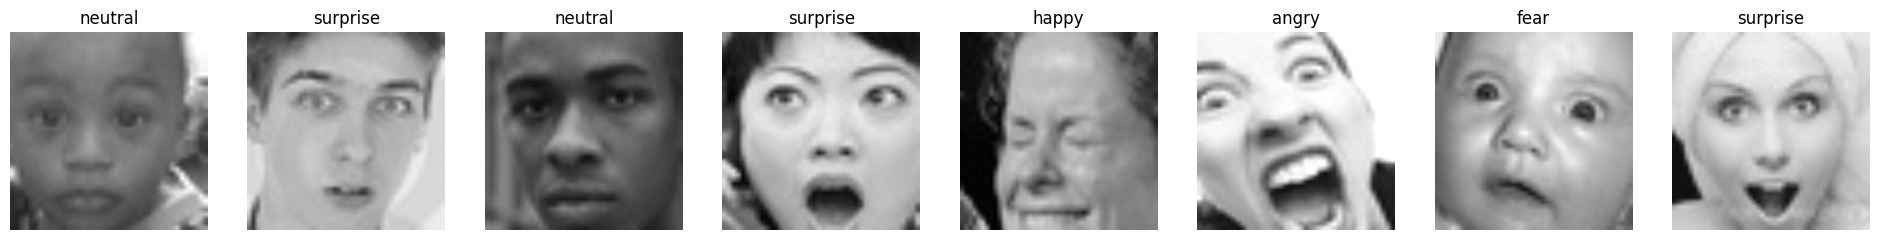

In [5]:
def show_batch(dl, class_names, n=8):
    """Show a few images from a DataLoader batch."""
    x, y = next(iter(dl))
    x = x[:n]  # take first n
    y = y[:n]

    # Undo normalization for plotting
    inv_mean = torch.tensor([0.485, 0.456, 0.406])
    inv_std  = torch.tensor([0.229, 0.224, 0.225])
    x = x * inv_std[None,:,None,None] + inv_mean[None,:,None,None]

    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i, ax in enumerate(axes):
        ax.imshow(x[i].permute(1,2,0).clamp(0,1))
        ax.set_title(class_names[y[i].item()])
        ax.axis("off")
    plt.show()
train_dl, val_dl, test_dl, num_classes, full_train, train_ds = build_dls(
    DATA_ROOT, IMG_SIZE, BATCH, WORKERS, VAL_SPLIT
)

print("Classes:", full_train.classes)
show_batch(train_dl, full_train.classes, n=8)

## HF MAE classifier

In [6]:
class HFMaeClassifier(nn.Module):
    def __init__(self, model_name: str, num_classes: int = 7):
        super().__init__()
        self.encoder = ViTMAEModel.from_pretrained(model_name)
        hid = self.encoder.config.hidden_size
        self.head = nn.Sequential(
            nn.LayerNorm(hid),
            nn.Linear(hid, num_classes)
        )
    def forward(self, x):
        out = self.encoder(pixel_values=x)
        cls = out.last_hidden_state[:, 0]
        return self.head(cls)

## Evaluation helpers

In [7]:
@torch.no_grad()
def evaluate(model_eval, dl):
    model_eval.eval()
    y_true, y_pred = [], []
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = model_eval(x)
        pred = logits.argmax(1)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    acc = (np.array(y_true) == np.array(y_pred)).mean() * 100
    return acc, classification_report(y_true, y_pred, digits=4), confusion_matrix(y_true, y_pred)

In [8]:
@torch.no_grad()
def evaluate_tta(model_eval, dl):  # horizontal flip TTA
    model_eval.eval()
    y_true, y_pred = [], []
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits1 = model_eval(x)
        logits2 = model_eval(torch.flip(x, dims=[3]))
        logits = (logits1 + logits2) / 2
        pred = logits.argmax(1)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    acc = (np.array(y_true) == np.array(y_pred)).mean() * 100
    return acc, classification_report(y_true, y_pred, digits=4), confusion_matrix(y_true, y_pred)

## Training utilities

In [9]:
def hf_mae_count_blocks(model):
    names = [n for n,_ in model.encoder.named_parameters()]
    pat = re.compile(r'(?:^|\.)(?:vit\.)?encoder\.layer\.(\d+)\.')
    idxs = [int(m.group(1)) for n in names for m in [pat.search(n)] if m]
    return (max(idxs)+1) if idxs else 0

In [10]:
def freeze_first_k_blocks_hf(model, k):
    # freeze embeddings (handles vit.* and plain embeddings.*)
    for n,p in model.encoder.named_parameters():
        if 'embeddings.' in n:
            p.requires_grad = False

    # freeze first k encoder blocks (supports vit.encoder.layer.* and encoder.layer.*)
    pat = re.compile(r'(?:^|\.)(?:vit\.)?encoder\.layer\.(\d+)\.')
    total = hf_mae_count_blocks(model)
    for n,p in model.encoder.named_parameters():
        m = pat.search(n)
        if m and int(m.group(1)) < k:
            p.requires_grad = False
    print(f"[freezer] Found {total} blocks. Froze embeddings + blocks [0..{k-1}].")

In [11]:
def unfreeze_all_hf(model):
    for p in model.parameters(): p.requires_grad = True
    print("[freezer] Unfroze all layers.")

In [12]:
class EMA:
    def __init__(self, model, decay=0.999):
        import copy
        self.decay = decay
        self.shadow = copy.deepcopy(model).eval()
        for p in self.shadow.parameters():
            p.requires_grad = False
    @torch.no_grad()
    def update(self, model):
        for s, p in zip(self.shadow.state_dict().values(), model.state_dict().values()):
            s.mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

In [13]:
def mixup(x, y, alpha=0.2, num_classes=7):
    if alpha <= 0:
        return x, F.one_hot(y, num_classes).float()
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x2 = x[idx]
    y1 = F.one_hot(y, num_classes).float()
    y2 = y1[idx]
    return lam * x + (1 - lam) * x2, lam * y1 + (1 - lam) * y2

In [14]:
def ce_soft(logits, soft_targets):
    return -(soft_targets * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

## Supervised fine-tune

In [15]:
loss_history = []
val_acc_history = []

In [16]:
def finetune_supervised(
    data_root=DATA_ROOT,
    model_name=MODEL_NAME,
    img_size=IMG_SIZE,
    batch_size=BATCH,
    workers=WORKERS,
    epochs=80,
    # warmup + freeze/unfreeze
    warmup_epochs=10,
    k_blocks_to_freeze=4,  # ~30% of 12 for MAE-Base
    # LRs
    lr_enc=3e-5,
    lr_head=1.5e-4,
    wd=5e-2,
    # regularization
    label_smoothing=0.1,
    mixup_alpha=0.2,
    # EMA + TTA
    ema_decay=0.999,
    use_tta=True,
    # aug strength
    stronger_aug=True,
    seed=42
):
    # dataloaders
    train_dl, val_dl, test_dl, num_classes, full_train, train_ds = build_dls(
        data_root, img_size, batch_size, workers, VAL_SPLIT, seed=seed, stronger_aug=stronger_aug
    )

    # model
    model = HFMaeClassifier(model_name, num_classes=num_classes).to(device)

    # freeze early blocks for warmup
    try:
      freeze_first_k_blocks_hf(model, k=k_blocks_to_freeze)
    except Exception as e:
      print("Could not freeze blocks:", e)

    # param groups
    enc_params, head_params = [], []
    for n, p in model.named_parameters():
        (head_params if "head" in n else enc_params).append(p)

    optimizer = torch.optim.AdamW(
        [{"params": enc_params, "lr": lr_enc},
         {"params": head_params, "lr": lr_head}],
        weight_decay=wd
    )

    # scheduler: warmup + cosine
    from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs),
            CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs),
        ],
        milestones=[warmup_epochs],
    )

    # class-balanced loss when MixUp is off
    if hasattr(train_ds, "indices"):
        labels = [full_train.samples[i][1] for i in train_ds.indices]
    else:
        labels = [y for _, y in train_ds.samples]
    freq = Counter(labels)
    N = len(labels)
    class_weights = torch.tensor([N / freq[c] for c in range(num_classes)], device=device, dtype=torch.float)
    ce_weighted = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

    # EMA
    ema = EMA(model, decay=ema_decay)

    best = 0.0
    for ep in range(epochs):
        model.train(); losses = []
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            if mixup_alpha > 0:
                x, y_soft = mixup(x, y, alpha=mixup_alpha, num_classes=num_classes)
                logits = model(x)
                loss = ce_soft(logits, y_soft)
            else:
                logits = model(x)
                loss = ce_weighted(logits, y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            ema.update(model)
            losses.append(loss.item())

        # unfreeze all after warmup
        if ep + 1 == warmup_epochs:
            unfreeze_all_hf(model)

        scheduler.step()
        va, _, _ = evaluate(ema.shadow, val_dl)
        print(f"[FT {ep+1}/{epochs}] loss={np.mean(losses):.4f} val_acc={va:.2f}")
        loss_history.append(np.mean(losses))
        val_acc_history.append(va)
        best = max(best, va)

    print("Best val acc (finetune):", best)

    # test with EMA (+ optional TTA)
    if use_tta:
        ta, rep, cm = evaluate_tta(ema.shadow, test_dl)
    else:
        ta, rep, cm = evaluate(ema.shadow, test_dl)

    print("Test acc (finetune):", ta)
    print(rep)
    print(cm)
    return model

## Usage

In [17]:
_ = finetune_supervised(
    data_root=DATA_ROOT,
    model_name=MODEL_NAME,            
    epochs=80,
    warmup_epochs=10,
    k_blocks_to_freeze=4,
    lr_enc=3e-5,
    lr_head=1.5e-4,
    label_smoothing=0.1,
    mixup_alpha=0.2,
    ema_decay=0.999,
    use_tta=True,
    stronger_aug=True
)

[freezer] Found 12 blocks. Froze embeddings + blocks [0..3].
[FT 1/80] loss=1.7723 val_acc=14.81


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 2/80] loss=1.5935 val_acc=16.27


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 3/80] loss=1.4681 val_acc=25.85


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 4/80] loss=1.4131 val_acc=35.64


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 5/80] loss=1.3698 val_acc=40.49


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 6/80] loss=1.3513 val_acc=45.89


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 7/80] loss=1.3351 val_acc=48.50


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 8/80] loss=1.2909 val_acc=50.17


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 9/80] loss=1.2577 val_acc=52.06


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[freezer] Unfroze all layers.
[FT 10/80] loss=1.2838 val_acc=53.10


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 11/80] loss=1.2928 val_acc=55.47


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 12/80] loss=1.2370 val_acc=56.10


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 13/80] loss=1.2013 val_acc=57.53


/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hilalevi/miniconda3/envs/deep/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

[FT 14/80] loss=1.2016 val_acc=57.77
[FT 15/80] loss=1.2093 val_acc=58.43
[FT 16/80] loss=1.2037 val_acc=59.55
[FT 17/80] loss=1.1769 val_acc=59.97
[FT 18/80] loss=1.1510 val_acc=60.84
[FT 19/80] loss=1.1470 val_acc=61.29
[FT 20/80] loss=1.1466 val_acc=62.33
[FT 21/80] loss=1.1304 val_acc=62.09
[FT 22/80] loss=1.1232 val_acc=62.75
[FT 23/80] loss=1.1373 val_acc=62.02
[FT 24/80] loss=1.1126 val_acc=63.07
[FT 25/80] loss=1.1067 val_acc=63.69
[FT 26/80] loss=1.0857 val_acc=62.54
[FT 27/80] loss=1.0858 val_acc=63.24
[FT 28/80] loss=1.0758 val_acc=63.87
[FT 29/80] loss=1.0747 val_acc=63.87
[FT 30/80] loss=1.0445 val_acc=63.34
[FT 31/80] loss=1.0724 val_acc=63.69
[FT 32/80] loss=1.0366 val_acc=63.94
[FT 33/80] loss=1.0714 val_acc=64.25
[FT 34/80] loss=1.0470 val_acc=64.39
[FT 35/80] loss=1.0269 val_acc=64.53
[FT 36/80] loss=1.0053 val_acc=63.24
[FT 37/80] loss=0.9890 val_acc=65.23
[FT 38/80] loss=0.9866 val_acc=64.91
[FT 39/80] loss=0.9579 val_acc=65.12
[FT 40/80] loss=0.9616 val_acc=63.73
[

## Results Visualization

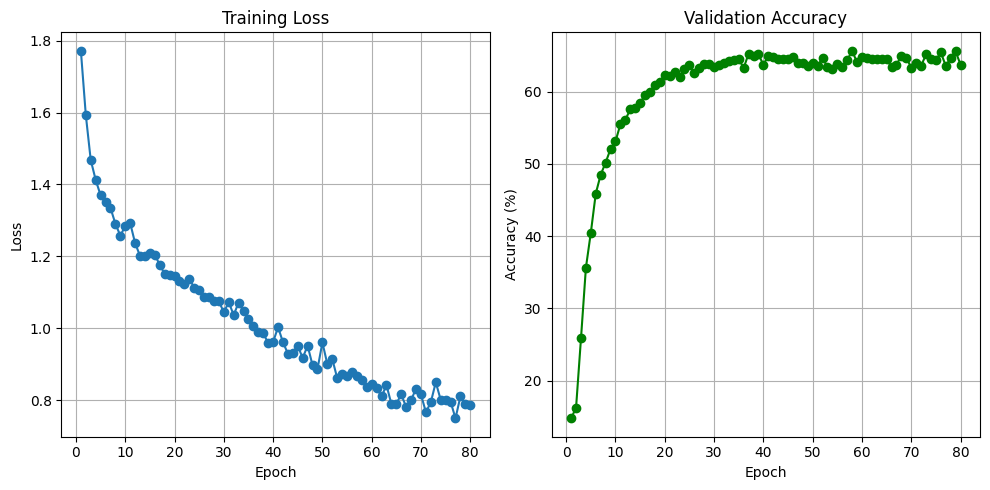

In [18]:
epochs_list = range(1, len(loss_history)+1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_list, loss_history, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_list, val_acc_history, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()
